## Informatics Collaboration Network - Full Graph

### Setup

In [1]:
# %load_ext autoreload
# %autoreload 2
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, csv
import networkx as nx
from helper import *
import cPickle as pkl

In [2]:
# The lookup tables:
lookup_pub = pd.read_pickle(
    path = '../data/lookup_pub.pkl')
pd_poinf = pd.read_pickle('../data/lookup_poinf.pkl')

In [3]:
# Only need the institute_clas and id:
pd_poinf.drop(
    labels=['full_name', 'last_name', 'first_name', 'institute', 'alias'],
    inplace=True,
    axis=1)

In [4]:
pd_poinf.head(3)

,perseonal_url,position,parent,institute_class
id,,,,
23d17ab4-123f-4929-9373-763bd7587df8,http://www.research.ed.ac.uk/portal/en/persons...,visitor official visitor,school of informatics,0
d089bb44-7d0b-4b3f-b556-27def993d1d1,http://www.research.ed.ac.uk/portal/en/persons...,lecturer in artificial intelligence,school of informatics,1
ecd799fb-4f63-44ae-a078-b009099f2c8c,http://www.research.ed.ac.uk/portal/en/persons...,research fellow,school of informatics,2


In [5]:
institutes = pkl.load(open('../data/institutes.pkl'))

In [6]:
# Create a color map for each institute:
inst_by_color = {
    0: 'xkcd:silver',
    1: 'xkcd:cyan',
    2: 'xkcd:magenta',
    3: 'xkcd:indigo',
    4: 'xkcd:red',
    5: 'xkcd:lime',
    6: 'xkcd:goldenrod',
    7: 'xkcd:azure',
    8: 'xkcd:lavender',
    9: 'xkcd:grey green',
    10: 'xkcd:coral',
    'others': 'xkcd:claret'
}


---
## Full Graph Visualisation

In [7]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

In [8]:
g_full = nx.from_edgelist(all_edges)
pos = nx.spring_layout(g_full)

In [9]:
# light up the nodes based on the institutes they belong to:
def color_by_inst(g):
    node_color = []
    for node in g:
        if len(str(node)) > 5:
            k = int(pd_poinf.institute_class.loc[[str(node)]])
            node_color.append(inst_by_color[k])
        else:
            node_color.append(inst_by_color['others'])
    return node_color

In [10]:
def add_inst_labels(ax, with_legend=True):
    for label in institutes.values():
        ax.scatter(
            [0], [0],
            color=inst_by_color[label],
            label=[name for (name, _k) in institutes.items() if _k == label][0])
    ax.scatter([0],[0],
              color=inst_by_color['others'],
              label='external')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.scatter([0],[0], color='white', s=100, edgecolors='none')
    return ax

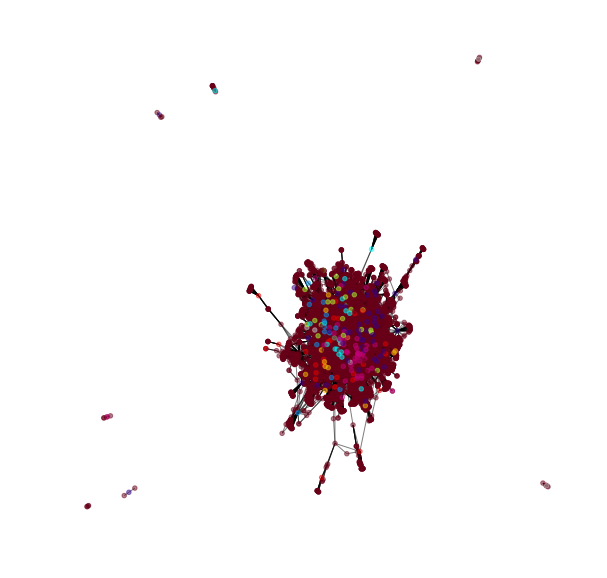

In [11]:
# visualise:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    g_full,
    pos=pos,
    with_labels=False,
    ax=ax,
    alpha=.5,
    node_size=20,
    node_color=color_by_inst(g_full)
)
plt.savefig("IMG/full_graph.pdf", format='pdf', 
            bbox_inches="tight")

### Global statistics

In [12]:
g_full.name = 'Full collaboration Graph'
print(nx.info(g_full))

Name: Full collaboration Graph
Type: Graph
Number of nodes: 7898
Number of edges: 35866
Average degree:   9.0823


#### Degree distribution
In this section, we calculate the degree distribution of the collaboration graph, also providing apis for further degree distribution calculation

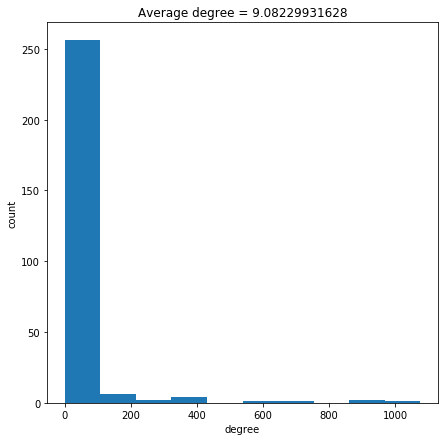

In [13]:
ax, degree_seq = degree_dist(g_full)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/goweiting/miniconda3/envs/infnet/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/goweiting/miniconda3/envs/infnet/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


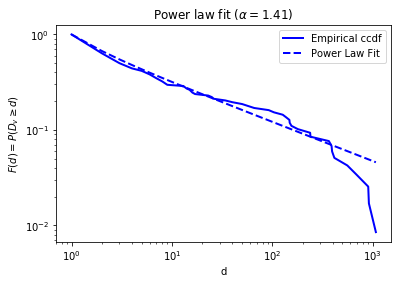

In [14]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
plt.savefig("IMG/full_graph-degreedist.pdf", format='pdf', 
            bbox_inches="tight")

#### Clustering Coefficients

In [15]:
cc = clustering_coeff(g_full)

In [16]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.813008680136


In [17]:
# The number of triangles for each nodes
triangle_nodes = nx.triangles(g_full)
transitivity_graph = nx.transitivity(g_full)

In [18]:
print('Transitivity:',transitivity_graph)

Transitivity: 0.291053234318


#### Distance Measure for subgraphs

In [19]:
gccs, percentage = generateGCC(g_full)

component 1: 99.48%
component 2: 0.15%
component 3: 0.09%
component 4: 0.08%
component 5: 0.06%
component 6: 0.05%
component 7: 0.05%
component 8: 0.04%


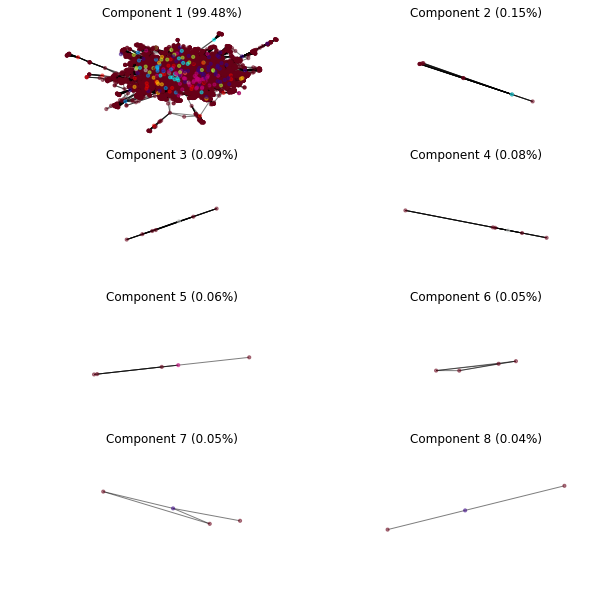

In [20]:
# display the connected components:
fig = plt.figure(figsize=(10,10))
num_col = len(gccs)/2
for i, g in enumerate(gccs,1):
    percent = percentage[i-1]
    ax = fig.add_subplot(num_col,2,i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        alpha=.5,
        node_size=10,
        pos=pos)
plt.savefig("IMG/full_graph-gccs.pdf", format='pdf', 
            bbox_inches="tight")

## Largest Connected Component

In [21]:
main_gcc = gccs[0]
pos_gcc = nx.spring_layout(main_gcc)

In [22]:
print('number of nodes in largest connected component:', len(main_gcc))

number of nodes in largest connected component: 7857


In [23]:
print(nx.info(main_gcc))

Name: Full collaboration Graph
Type: Graph
Number of nodes: 7857
Number of edges: 35783
Average degree:   9.1086


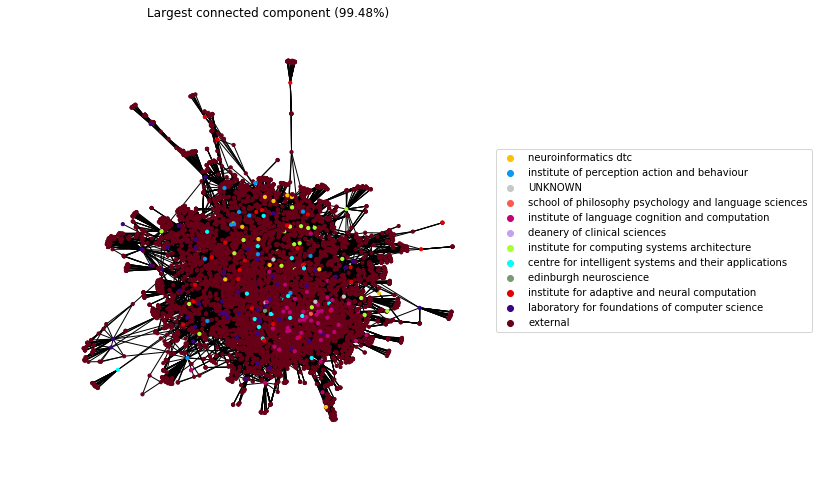

In [24]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=10,
    node_color=color_by_inst(main_gcc))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))
plt.savefig("IMG/full_graph-LargestCC.pdf", format='pdf', bbox_inches="tight")

### Statistics

#### Degree Distribution

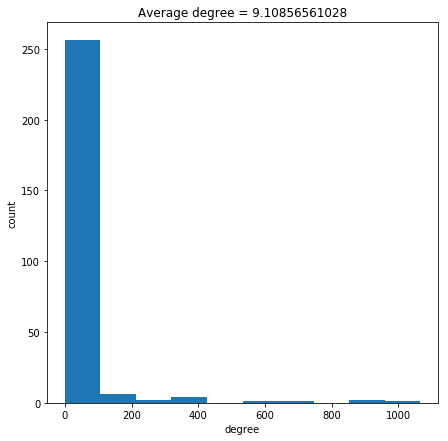

In [25]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


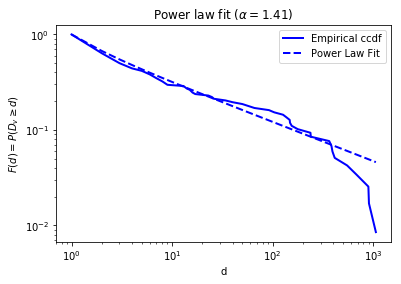

In [26]:
fig = power_law_fit(degree_seq)
plt.savefig("IMG/full_graph-LargestCC-powerlaw.pdf", format='pdf', 
            bbox_inches="tight")

#### Clustering coefficients

In [27]:
cc = clustering_coeff(main_gcc)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.812993641411


#### Average Path and Diameter

In [28]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 10


In [29]:
print('Average Path: ', nx.average_shortest_path_length(main_gcc)) # AVERAGE PATH

Average Path:  4.62115252216


### Community Detection
In this section, we use the [`community`](https://bitbucket.org/taynaud/python-louvain) package to detect communities in the largest connected component. 
We hypothesised that this will allow us to detect various institutes that have close working relationships

***Credit: https://blog.dominodatalab.com/social-network-analysis-with-networkx/***

In [30]:
import community

In [31]:
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]

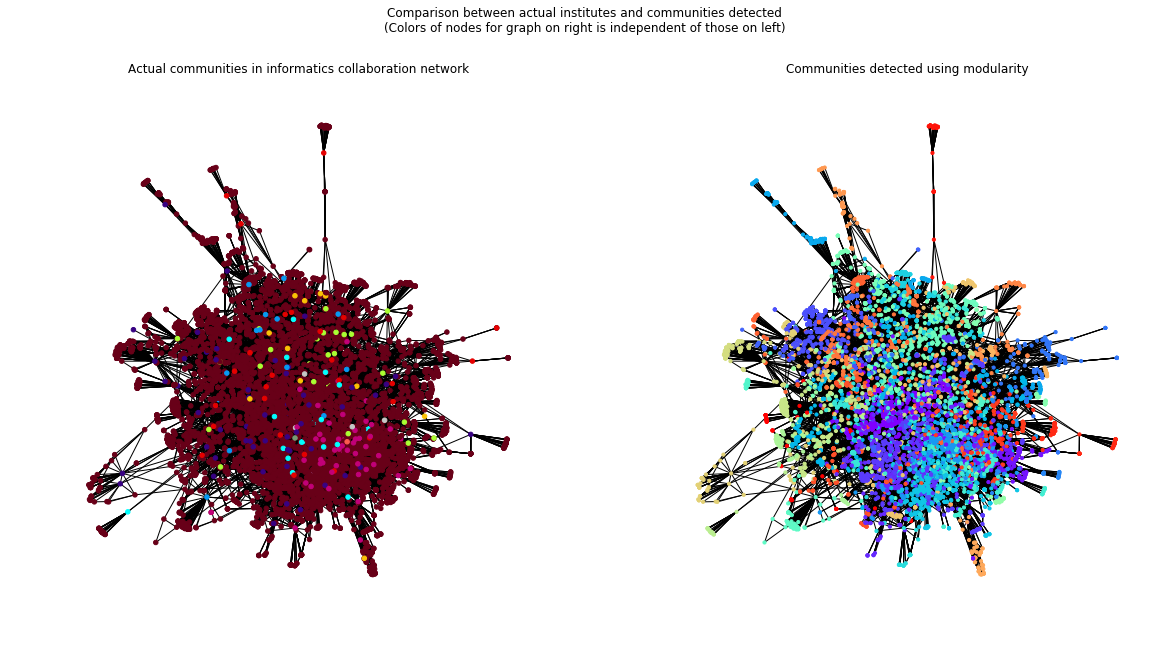

In [32]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=20,
    node_color=color_by_inst(main_gcc))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=10,
    with_labels=False)

plt.savefig(
    "IMG/full_graph-compareCommunities.pdf", format='pdf', bbox_inches="tight")

In [33]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

Number of communities detected = 40


In [34]:
poinf_in_gcc = [n for n in main_gcc.nodes if n in pd_poinf.index]
poinf_edge = [
    a for a in main_gcc.edges
    if a[0] in pd_poinf.index and a[1] in pd_poinf.index
]

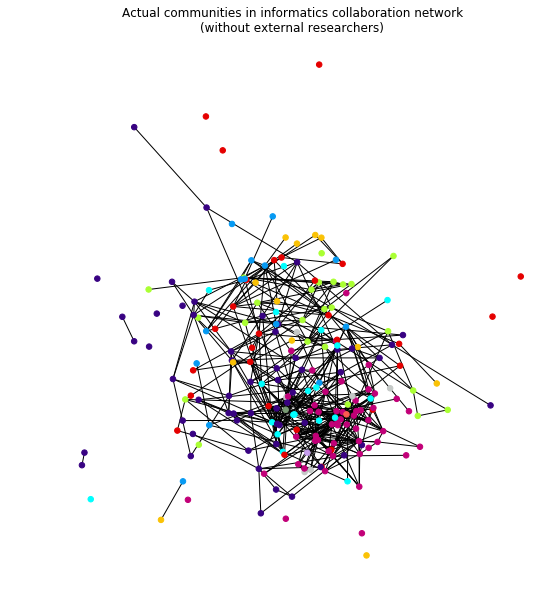

In [35]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network\n(without external researchers)')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=color_by_inst(nx.subgraph(main_gcc, poinf_in_gcc)))
plt.savefig(
    "IMG/full_graph-compareCommunities-big.pdf", format='pdf', bbox_inches="tight")

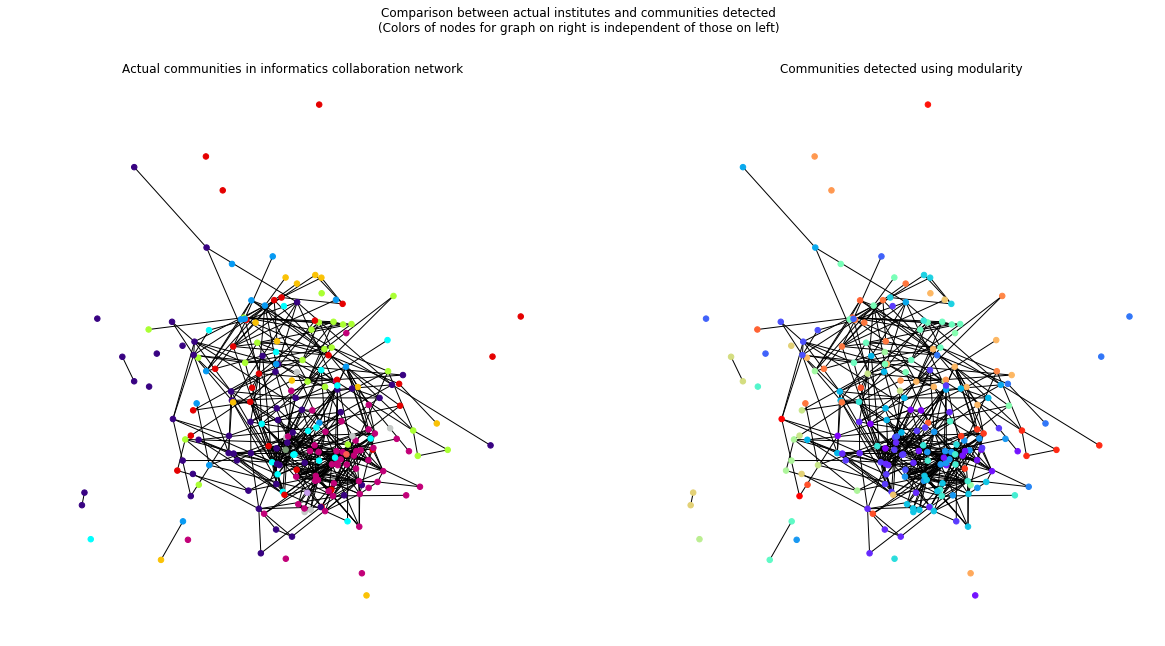

In [36]:
# Draw only nodes that are in informatics
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=color_by_inst(nx.subgraph(main_gcc, poinf_in_gcc)))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=[
        parts.get(node)
        for node in nx.subgraph(main_gcc, poinf_in_gcc).nodes()
    ],
    with_labels=False)

plt.savefig(
    "IMG/full_graph-compareCommunities-rmExt.pdf",
    format='pdf',
    bbox_inches="tight")

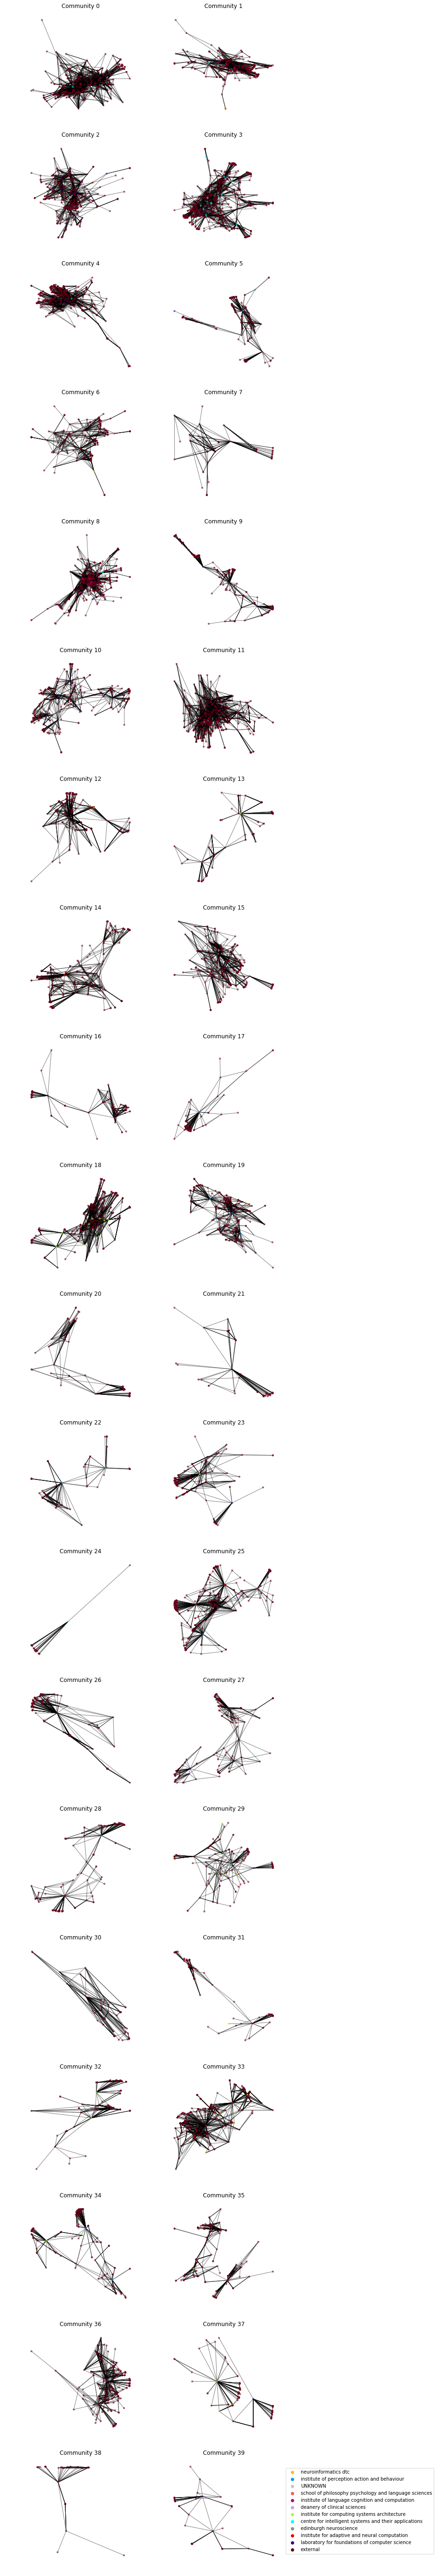

In [37]:
# plot each community:
fig = plt.figure(figsize=(10, 100))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(num_comm / 2, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(subG),
        node_size=10,
        alpha=.5,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "IMG/full_graph-compareSubCommunities.pdf", format='pdf', bbox_inches="tight")

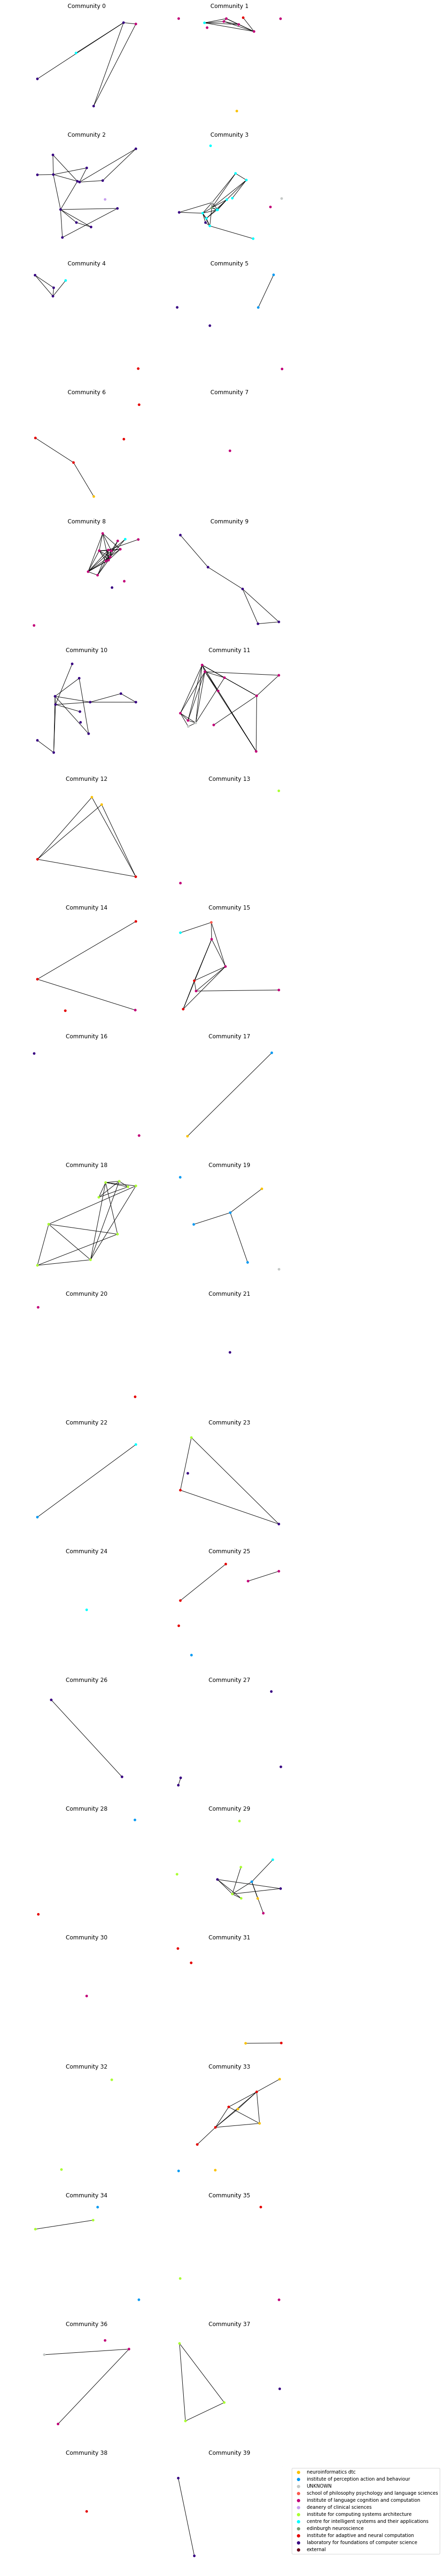

In [38]:
# plot each community:
fig = plt.figure(figsize=(10, 100))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(num_comm / 2, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    subsubG = nx.subgraph(subG, poinf_in_gcc)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    nx.draw_networkx(
        subsubG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(subsubG),
        node_size=20,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "IMG/full_graph-compareSubCommunities-rmExt.pdf",
    format='pdf',
    bbox_inches="tight")